# **Gravitational wave data analysis - Assignment 1**

---



0) Importing packages


---



In [114]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

In [120]:
from __future__ import division
import numpy
import lal
import lalsimulation
import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
import pandas as pd
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
%matplotlib inline
import pylab
from pycbc.catalog import Merger


# **Problem 1: Matched filter**

---



# **Part 1**

---



**1) Loading the data**

---



In [121]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



**2) Plots of the data prior to the downsampling**

---



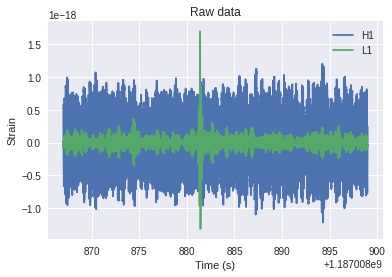

In [122]:
m = Merger('GW170817') # Merger of interest

data = {} # Retrieving data
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

# Plotting both strains
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.title('Raw data')
pylab.show()

**3) Downsampling the data**

---



In [123]:
# Packages
from pycbc.filter import highpass
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass

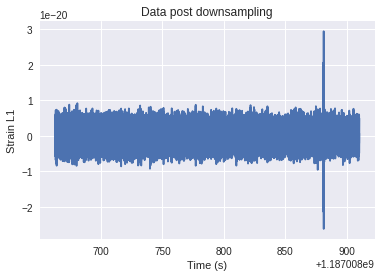

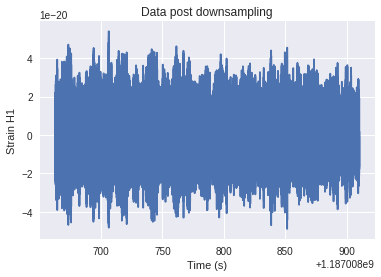

In [124]:
# Downloading the data + selecting 256 seconds that include the event time
merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['L1', 'H1']:
  ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                  '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224, 
                  end_time=merger.time + 32,
                  check_integrity=False)
  
 # Downsampling
  # Remove the low frequency content and downsample the data to 2048Hz
  strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
  # Remove the begining and ending spikes from the data
  strain[ifo] = strain[ifo].crop(4, 4)
  # Also create a frequency domain version of the data
  stilde[ifo] = strain[ifo].to_frequencyseries()

# Plots
# Plot of L1
pylab.plot(strain['L1'].sample_times, strain['L1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain L1')
pylab.title('Data post downsampling')
pylab.show()

# Plot of H1
pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain H1')
pylab.title('Data post downsampling')
pylab.show()

# **Part 2**

---




**1) Plot of the Power spectral density (PSD)**

---



In [125]:
# Packages
import pycbc.psd
from pycbc.psd import interpolate

Text(0.5, 1.0, 'Data Power Spectral Density')

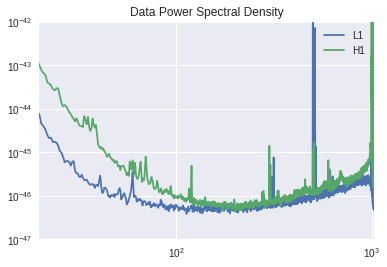

In [126]:
# Whitening the data in order to find the SNR
psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

# Plot the power spectral density of the data
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.title('Data Power Spectral Density')

In [127]:
# Packages
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q

**2) Matched filter**

---



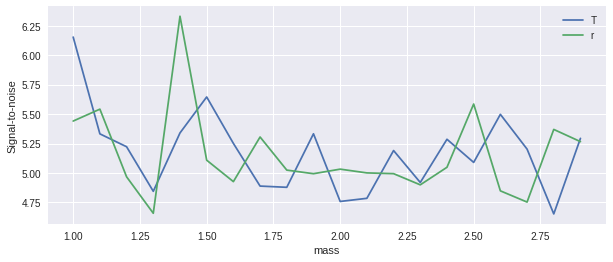

In [128]:
# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

mass1 = numpy.arange(1,3,0.1) # Mass range bewteen 1 to 3 Solar mass, in steps of 0.1
mass2 = mass1

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # For H1
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):

    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2", # Better approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=30)

    # Resizing the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=30)

    # Removing time corrupted by the template filter and the psd filter
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # for L1

ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
  
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2", # Better approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=30)

    # Resizing the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=30)

    # Removing time corrupted by the template filter and the psd filter
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# Plotting
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

**3) Max SNR**

---



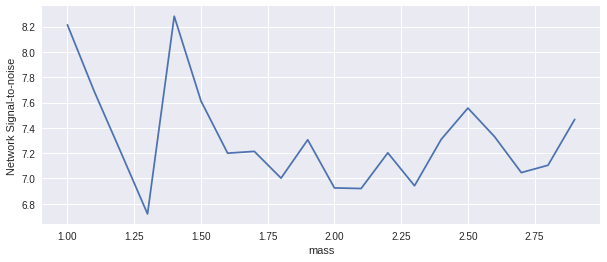

We found the best Mass1=Mass2 was 1.40 solar masses (detector frame)


In [129]:
# Finding the max SNR
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))

# Plotting
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

**4) Rescaling data**

---



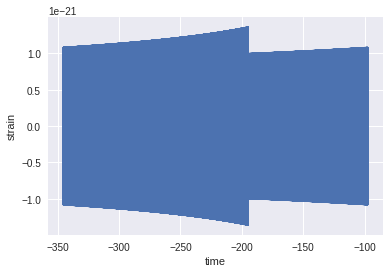

In [130]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 1.4 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# Plotting
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

**5) Finding the signal within noise**

---



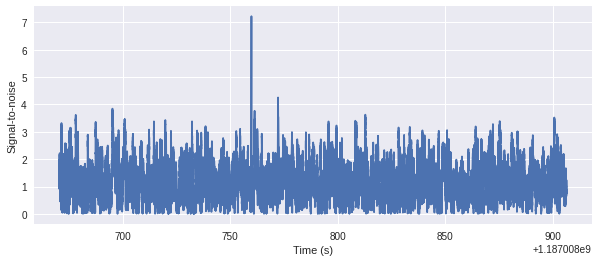

We found a signal at 1187008759.8428712s with SNR 7.2220023339019885


In [131]:
ifo = 'H1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
snr = snr.crop(4 + 4, 4)

# Plotting
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

**6) Fitting best match template waveform against data**

---



In [132]:
# Package
from pycbc.filter import sigma

In [133]:
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# Scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

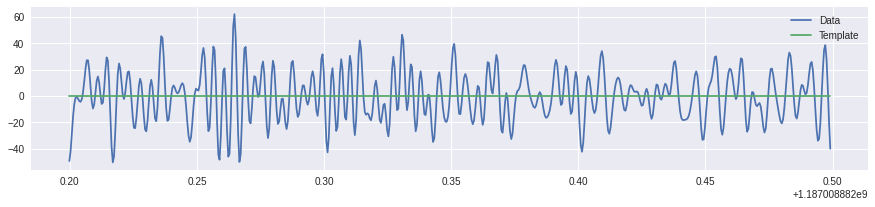

In [134]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# Apply a smoothing of the turnon of the template to avoid a transient
# From the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

# Plotting
pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

**7) Whitening the data**

---



In [135]:
# Data
m = Merger('GW170817') # Merger of interest

data = {} # Retrieving data
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

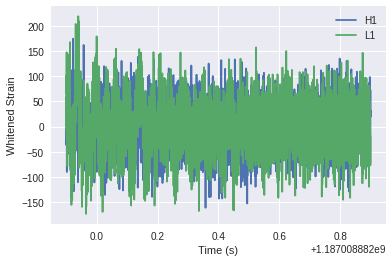

In [136]:
# Whitening the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

# Plotting
pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

**8) Highpass and lowpass filters**

---



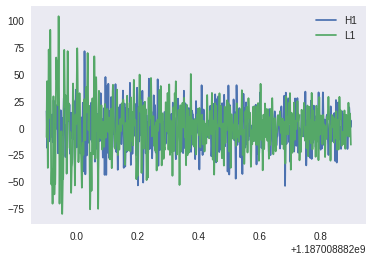

In [137]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

# Plotting
pylab.grid()
pylab.legend()
pylab.show()

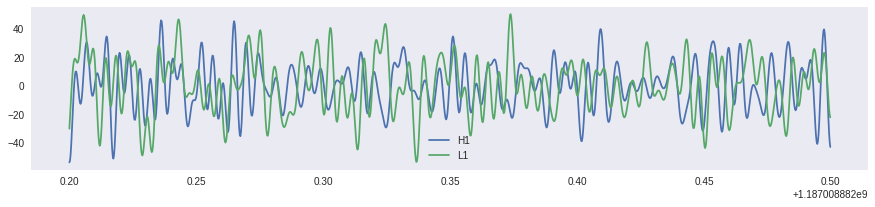

In [138]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

# Plotting
pylab.grid()
pylab.legend()
pylab.show()

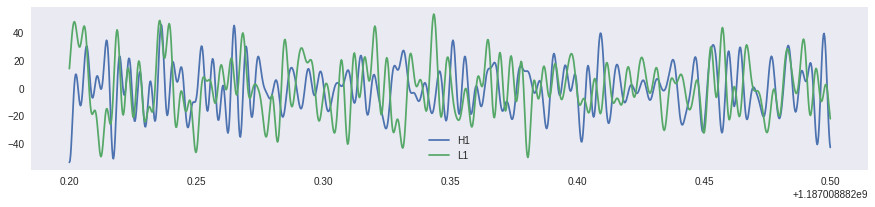

In [139]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

# Plotting
pylab.grid()
pylab.legend()
pylab.show()

**9) chirp structure of the signal over the time-freq. domain using q-transformation**

---



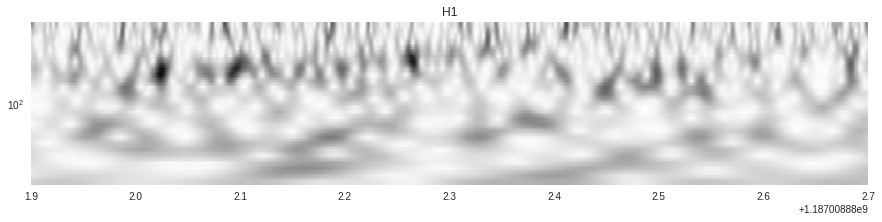

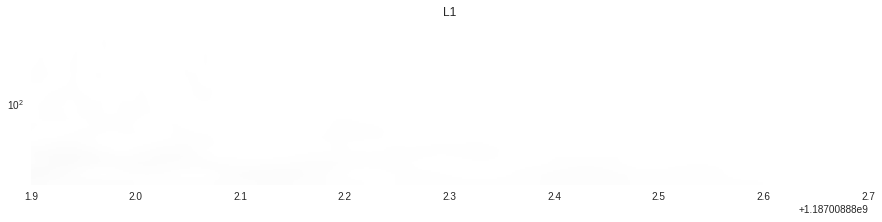

In [140]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

# **Part 3**

---



**1) Investigating the correlation in the parameter space of gravitational waves from compact binary coalescences**

---







In [141]:
f_low = 30
sample_rate = 4096
mass1 = numpy.arange(5, 15,0.10 ) # Mass range between 5 to 15 Solar masses
mass2 = mass1

mass_array = {}
mass_df = pd.DataFrame (mass_array, columns = ['mass','match'])

hp, hc = get_td_waveform(approximant = "EOBNRv2",
        mass1 = 10 ,
        mass2 = 10 ,
        f_lower = f_low,
        delta_t = 1.0 / sample_rate)

for i in range(len(mass1)):
    # Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    current_mass = m 

    sp, sc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     delta_t = 1.0 / sample_rate,
                     f_lower=f_low)

    # Resize the waveforms to the same length
    tlen = max ( len (sp), len (hp))
    sp.resize(tlen)
    hp.resize(tlen)

    # Generate the aLIGO PSD
    delta_f = 1.0 / sp . duration
    flen = tlen // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Matching

    m, i = match(hp, sp, psd = psd, low_frequency_cutoff = f_low)
    
    new_row = {'mass':current_mass, 'match':m}
    mass_df = mass_df.append(new_row, ignore_index=True)

**2) Plotting**

---



In [142]:
# Package
import matplotlib.pyplot as plt 


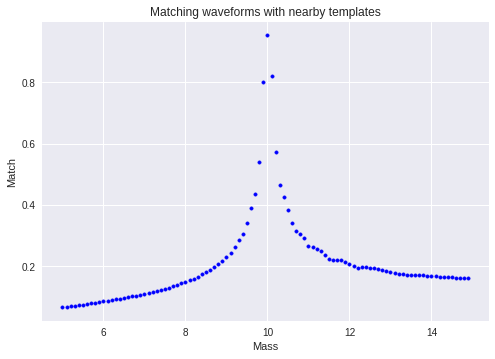

In [143]:
plt.style.use('seaborn')

x_data = mass_df['mass']
y_data = mass_df['match']

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")

plt.xlabel("Mass")
plt.ylabel("Match")
plt.title("Matching waveforms with nearby templates")
plt.show()

# **Problem 2: Detector noise**

---




##Part 1

---



**1) Mounting drive to access the data**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2) Loading data and estimating PSDs**

---



In [144]:
# Packages
from pycbc.psd import welch, interpolate
import pycbc.types 

In [145]:
d = numpy.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d
1.0/data.delta_t
psds = interpolate(welch(d), 1.0 / d.duration)

**3) Plotting PSD**

---



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Power Spectral Density')

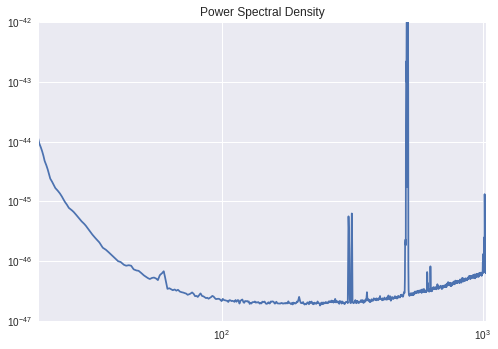

In [146]:
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.title('Power Spectral Density')

**4) Matched filtering + max SNR**

---



In [147]:
# Packages
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform

In [ ]:
# The following cell takes a long time to run

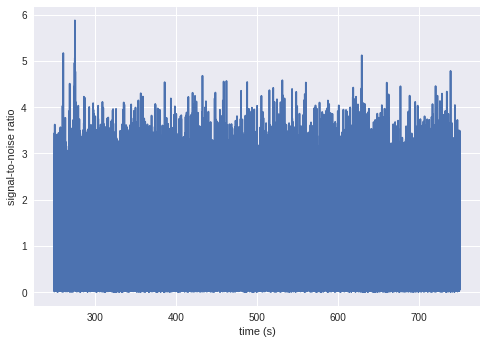

Maximum SNR 5.877458901888036


In [148]:
flow = 30 #Hz
stilde = data.to_frequencyseries()

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

mass1 = numpy.arange(5,10,0.1) # Mass range bewteen 5 to  Solar mass, in steps of 0.1
mass2 = mass1

 # Generating a waveform with a given component mass; assumed equal mass, nonspinning
 # For H1

Snr_list = []
for i in range(0, len(mass1)):  
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                             mass1=mass1[i], mass2=mass2[i],
                             f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde)) 
  template = hp.cyclic_time_shift(hp.start_time) 
  snr = pycbc.filter.matched_filter(template, stilde, psd=psds,
                                      low_frequency_cutoff=flow)

  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
  Snr_list.append(max(abs(snr)))

snrs[i] =Snr_list

# Plotting
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print ( 'Maximum SNR', max(abs(snr)) )

In [ ]:
# Max SNR below 8 -> only noise, no signal.

#**Part 2**

---



**1) Whitening data**

---






In [149]:
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4 + 4, 4)

**2) Histogram of whitened data**

---



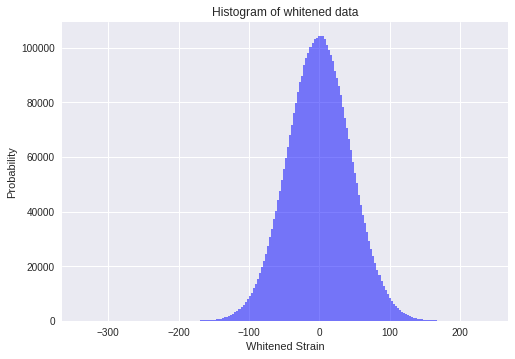

In [150]:
num_bins = 200
n, bins, patches = plt.hist(white_data, num_bins, facecolor='blue', alpha=0.5)

pylab.ylabel('Probability')
pylab.xlabel('Whitened Strain')
pylab.title('Histogram of whitened data')
pylab.show()

In [ ]:
# The whitened data indeed follows a Gaussian distribution with zero mean

# **Part 3**

---



**1) Creating an arbitrary waveform**

---



In [151]:
hp, hc = get_fd_waveform(approximant="TaylorF2",
mass1=3,
mass2=3,
delta_f=1.0/(200.0) ,
distance = 500,
f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc

**2) Testing whether the noise follows the stationary assumption or not**

---



In [152]:
# Package
from pycbc.filter import sigmasq

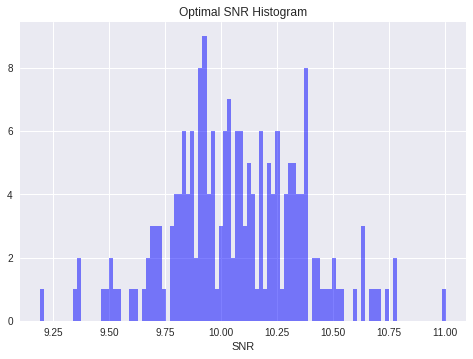

In [153]:
# SNR list
snr_list = []
sections = 200
l = len(data)
fract = round(l/sections)
for i in range(0, sections): # Chunks of data
  current_data = data[i*fract: (i+1)*fract]
  current_psd = pycbc.psd.interpolate(pycbc.psd.welch(current_data), hp.delta_f)
 
 # Calculating optimal SNR
  snr = (pycbc.filter.sigmasq(hp, current_psd))**0.5
  snr_list.append(abs(snr))

# Plotting the histogram
num_bins = 100
n, bins, patches = plt.hist(snr_list, num_bins, facecolor='blue', alpha=0.5)
pylab.xlabel("SNR")
pylab.title("Optimal SNR Histogram")
plt.show()

In [ ]:
# The distribution does not follow a Gaussian, 
# thereby it shows that in reality, the noise is not stationary Gaussian

# **Problem 3: Horizon distance of detectors**

---



# **Part 1**

---



**1) PSD for a LIGO detector**

---



In [154]:
# Packages
import pycbc.psd
import numpy as np

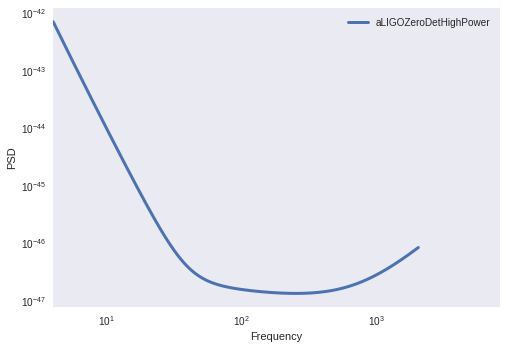

In [155]:
flow = 4.0 # Set up the lower cut off frequency
delta_f = 1.0/16
flen = int(2048.0/(delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf # Set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# Plotting
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower')

pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

**2) Estimating horizon distance for LIGO detector**

---



In [156]:
# Packages
from pycbc.filter import match 
from pycbc.psd import aLIGOZeroDetHighPower
import pandas as pd   

In [ ]:
# The following cell takes a (very) long time to run

In [ ]:
# Generating template waveform  
distance_array = {}
distance_df = pd.DataFrame (distance_array, columns = ['distance','SNR'])

f_low = 30
sample_rate = 4096

distance = numpy.arange(500, 5000, 1)

for d in distance:

  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=3,
                          mass2=3,
                          delta_f=1.0/(16.0),
                          distance = d,
                          f_lower=5.0,
                          f_final=4096.0)


  # Psd for LIGO
  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(4096.0/ (delta_f)) + 1
  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf

  # Calculating optimal SNR
  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5

  new_row = {'distance':d, 'SNR':SNR}
  distance_df = distance_df.append(new_row, ignore_index=True)


**3) Plotting distance vs. SNR**

---



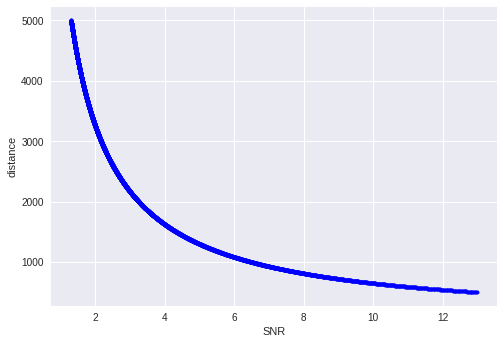

     distance       SNR
302     802.0  8.092597
303     803.0  8.082519
304     804.0  8.072466
305     805.0  8.062438
306     806.0  8.052435
307     807.0  8.042457
308     808.0  8.032503
309     809.0  8.022574
310     810.0  8.012670
311     811.0  8.002790
312     812.0  7.992934
313     813.0  7.983103
314     814.0  7.973296
315     815.0  7.963512
316     816.0  7.953753
317     817.0  7.944018
318     818.0  7.934306
319     819.0  7.924619
320     820.0  7.914954
321     821.0  7.905314


In [ ]:
plt.style.use('seaborn')

x_data = distance_df['SNR']
y_data = distance_df['distance']

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")

plt.xlabel("SNR")
plt.ylabel("distance")

plt.title("")
plt.show()

SNR_df = distance_df.loc[(distance_df['SNR'] > 7.9) & (distance_df['SNR'] < 8.1)]

print(SNR_df)

**4) Horizon plot**

---



In [ ]:
# Generating template waveform  
snr_array = {}
snr_df = pd.DataFrame (snr_array, columns = ['SNR','total_mass'])

f_low = 30
sample_rate = 4096

mass = numpy.arange(2, 2000, 10)

for m in mass:

  #Generate the two waveforms to compare

  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=m,
                          mass2=m,
                          delta_f=1.0/(16.0),
                          distance = 800,
                          f_lower=5.0,
                          f_final=2048)

  # PSD for LIGO
  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(2048.0/ (delta_f)) + 1
  psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf

  #calculate optimal SNR
  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5

  new_row = {'total_mass':2*m, 'SNR':SNR}
  snr_df = snr_df.append(new_row, ignore_index=True)

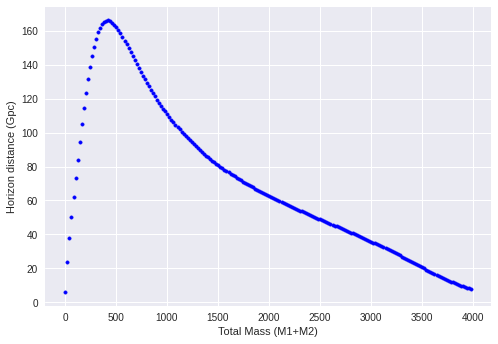

In [ ]:
plt.style.use('seaborn')

x_data = snr_df['total_mass']
y_data = snr_df['SNR']

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")

plt.xlabel("Total Mass (M1+M2)")
plt.ylabel("Horizon distance (Gpc)")

plt.show()

In [ ]:
# What we can see from the graph: 
# at 0, the two binary black holes are starting to coalesce
# and thereby creating gravitational waves - 
# which are disturbances of the curvature of spacetime. 
# At the peak (~170 Gpc), the two black holes have merged, which is the biggest disturbance
# After that, the disturbances steadily decrease until zero


# **Part 2**

---



**1) PSD for Einstein Telescope (ET)**

---



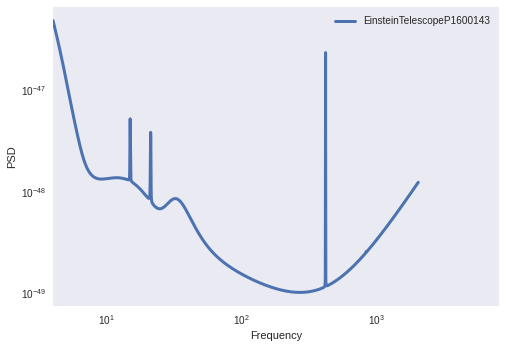

In [157]:
flow = 4.0 # Set up the lower cut off frequency
delta_f = 1.0/16
flen = int(2048.0/(delta_f)) + 1
psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf # Set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# Plotting
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='EinsteinTelescopeP1600143')

pylab.xlim(xmin=flow, xmax=8192)
pylab.xlabel('Frequency')
pylab.ylabel('PSD')
pylab.legend()
pylab.grid()
pylab.show()

**2) Estimating horizon distance for ET**

---



In [158]:
# Generating template waveform  

distance_array = {}
distance_df = pd.DataFrame (distance_array, columns = ['distance','SNR'])

f_low = 30
sample_rate = 4096

distance = numpy.arange(500, 5000, 10)

for d in distance:

  #Generate the two waveforms to compare


  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=3,
                          mass2=3,
                          delta_f=1.0/(16.0),
                          distance = d,
                          f_lower=5.0,
                          f_final=4096.0)


  # PSD for ET
  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(4096.0/ (delta_f)) + 1
  psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf

  # Calculating optimal SNR
  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5

  new_row = {'distance':d, 'SNR':SNR}
  distance_df = distance_df.append(new_row, ignore_index=True)

**3) Plotting distance vs. SNR**

---



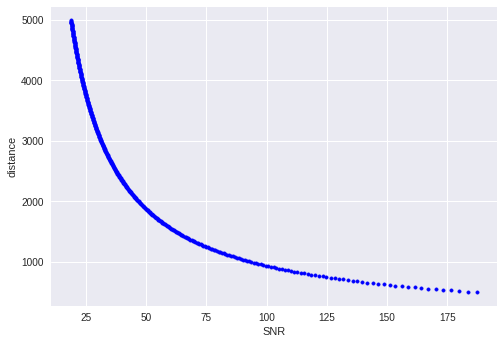

In [159]:
plt.style.use('seaborn')

x_data = distance_df['SNR']
y_data = distance_df['distance']

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")

plt.xlabel("SNR")
plt.ylabel("distance")

plt.show()

**4) Horizon plot**

---

In [160]:
# Generating template waveform  
snr_array = {}
snr_df = pd.DataFrame (snr_array, columns = ['SNR','total_mass'])

f_low = 30
sample_rate = 4096

mass = numpy.arange(2, 2000, 10)

for m in mass:

  #Generate the two waveforms to compare

  hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=m,
                          mass2=m,
                          delta_f=1.0/(16.0),
                          distance = 800,
                          f_lower=5.0,
                          f_final=2048)


  # PSD for ET
  flow = 4.0 #set lower cut off frequency 
  delta_f = 1.0/16
  flen = int(2048.0/ (delta_f)) + 1
  psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
  psd.data[:int(flow/delta_f)] = np.inf  #set the value outside the frequency range to infinity
  psd.data[-1] = np.inf

  # Calculating optimal SNR
  #hp is template waveform 
  SNR = (pycbc.filter.sigmasq(hp,psd))**0.5

  new_row = {'total_mass':2*m, 'SNR':SNR}
  snr_df = snr_df.append(new_row, ignore_index=True)

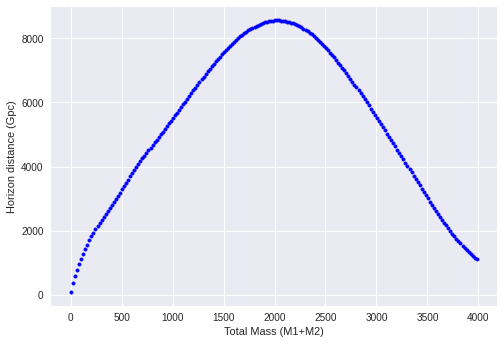

In [161]:
plt.style.use('seaborn')

x_data = snr_df['total_mass']
y_data = snr_df['SNR']

plt.scatter(x_data, y_data, c='blue', label='data', marker=".")

plt.xlabel("Total Mass (M1+M2)")
plt.ylabel("Horizon distance (Gpc)")

plt.show()

In [ ]:
# Same here as for the LIGO detector, whereas the merging occurs at a different 
# distance for different masses
# It makes sense that the data is not the same as the detectors are not located 
# at the place, and their sensitivity might differ
# That is the reason why we need multiple detectors for gravitational waves